In [1]:
# Задача. Варьируя параметры ансамбля в подходах блэндинг и стэкинг, обучить оптимальный классификатор.
# Визуализировать графики зависимости предсказания от параметров модели.

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
nltk.download('stopwords')

/Users/denisdavydov/ml-homework/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/denisdavydov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
dataset = load_dataset('json', data_files={'train': 'train.jsonl', 'test': 'validation.jsonl'})

vectorizer = CountVectorizer(max_features=500, min_df=4, max_df=0.7, stop_words=stopwords.words('english'))
X_train_vec = vectorizer.fit_transform(dataset['train']['text'])

vocabulary = vectorizer.get_feature_names_out()

tfidf = TfidfTransformer()
X_train_idf = tfidf.fit_transform(X_train_vec)
X_test_vec = vectorizer.transform(dataset['test']['text'])
X_test_idf = tfidf.transform(X_test_vec)

X_train = X_train_idf.toarray()
X_test = X_test_idf.toarray()
y_train = dataset['train']['label']
y_test = dataset['test']['label']

X_train_0, X_train_1, y_train_0, y_train_1 = train_test_split(X_train, y_train, test_size=0.33, random_state=42)


In [6]:
# Определение моделей для блэндинга и стэкинга
base_models = [
    ("AdaBoost", AdaBoostClassifier(n_estimators=50, random_state=42)),
    ("GradientBoosting", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("RandomForest", RandomForestClassifier(n_estimators=100, random_state=42))
]

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(random_state=42)
)

# Результаты для базовых моделей
results = {}


In [7]:
for model_name, model in base_models:
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy:.2f}")


Training AdaBoost...
AdaBoost Accuracy: 0.35
Training GradientBoosting...
GradientBoosting Accuracy: 0.65
Training RandomForest...
RandomForest Accuracy: 0.65


In [8]:
# Результаты для стэкинга
print("Training Stacking Model...")
stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
results["Stacking"] = stacking_accuracy
print(f"Stacking Model Accuracy: {stacking_accuracy:.2f}")


Training Stacking Model...
Stacking Model Accuracy: 0.65


In [9]:
from sklearn.linear_model import LogisticRegression
import numpy as np


In [10]:
base_predictions = []
for model_name, model in base_models:
    model.fit(X_train_0, y_train_0)
    base_predictions.append(model.predict(X_train_1))
base_predictions = np.array(base_predictions).T


In [13]:
blending_meta_model = LogisticRegression(random_state=42)
blending_meta_model.fit(base_predictions, y_train_1)


/Users/denisdavydov/ml-homework/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [14]:
test_base_predictions = []
for _, model in base_models:
    test_base_predictions.append(model.predict(X_test))
test_base_predictions = np.array(test_base_predictions).T


In [15]:
blending_predictions = blending_meta_model.predict(test_base_predictions)
blending_accuracy = accuracy_score(y_test, blending_predictions)
results["Blending"] = blending_accuracy


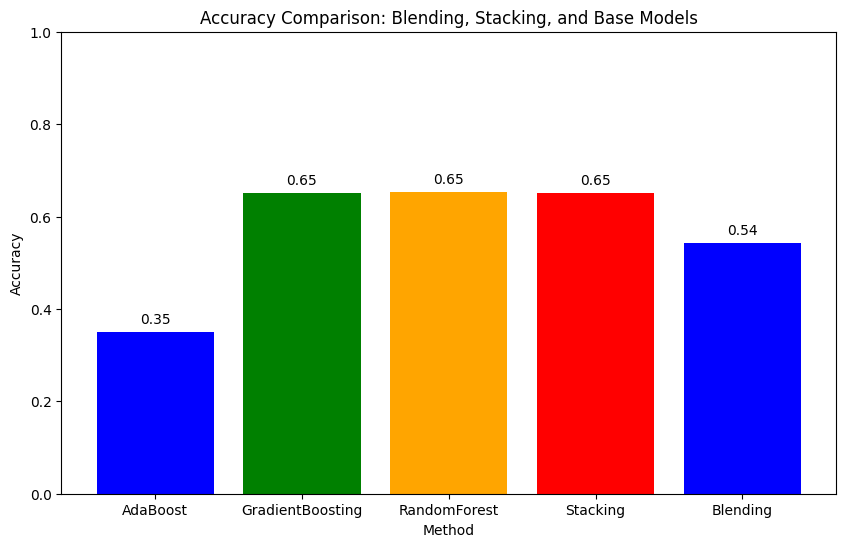

In [16]:
# Bar chart visualizing accuracy of all methods
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=["blue", "green", "orange", "red"])
plt.title("Accuracy Comparison: Blending, Stacking, and Base Models")
plt.ylabel("Accuracy")
plt.xlabel("Method")
plt.ylim(0, 1)
for i, acc in enumerate(results.values()):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center')
plt.show()